Test slab_model.py
==================

Jinbo Wang

Jinbo.Wang@jpl.nasa.gov

Revision history

1. last update: 12/31/2021 copied from full_wacm-scenario.ipynb
1. pick up on 4/25/2023, use the new (old now) odysea_class to generate the time stamps. 

# WaCM was generated from the original

Highpass filtering and detides will be performed on the simulated WaCM data.

In [96]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
import glob 
import os

import sys
sys.path.append('../src')
sys.path.append('../')

import slab_model
import pylab as plt
import numpy as np
import xarray as xr
from scipy.io import loadmat
import pandas as pd
import pickle
import odysea_class
import utils
from scipy import signal

xrod=xr.open_dataset

import coas

In [149]:
coas_model = coas.COAS(days=[20,35])

display(coas_model.U)
display(coas_model.TX)


<xarray.Dataset>
Dimensions:  (time: 360, lat: 1126, lon: 2250)
Coordinates:
  * time     (time) datetime64[ns] 2020-02-08T21:00:00 ... 2020-02-23T20:00:00
  * lat      (lat) float64 -89.94 -89.78 -89.62 -89.46 ... 89.58 89.74 89.9 90.0
  * lon      (lon) float64 -179.9 -179.8 -179.6 -179.5 ... 179.6 179.7 179.9
Data variables:
    U        (time, lat, lon) float64 dask.array<chunksize=(1, 1126, 2250), meta=np.ndarray>

<xarray.Dataset>
Dimensions:  (time: 360, lat: 1126, lon: 2250)
Coordinates:
  * time     (time) datetime64[ns] 2020-02-08T21:00:00 ... 2020-02-23T20:00:00
  * lat      (lat) float64 -89.94 -89.78 -89.62 -89.46 ... 89.58 89.74 89.9 90.0
  * lon      (lon) float64 -179.9 -179.8 -179.6 -179.5 ... 179.6 179.7 179.9
Data variables:
    TX       (time, lat, lon) float64 dask.array<chunksize=(1, 1126, 2250), meta=np.ndarray>

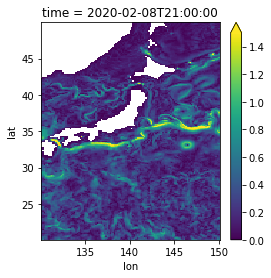

In [136]:
fig=plt.figure(figsize=(4,4))
aa=coas_model.V['V'][0,...].sel(lon=slice(130,150),lat=slice(20,50))
bb=coas_model.U['U'][0,...].sel(lon=slice(130,150),lat=slice(20,50))
((aa**2+bb**2)**0.5).plot(vmin=0,vmax=1.5)
plt.savefig('figures/KE_map_coas_example.png',dpi=200)

In [139]:
lon0,lat0=-145,35
ddeg = 0.25
model_time=coas_model.U['U']
u=coas_model.U['U'].sel(lon=slice(lon0-ddeg,lon0+ddeg),
                        lat=slice(lat0-ddeg,lat0+ddeg))
u

<xarray.DataArray 'U' (time: 960, lat: 3, lon: 3)>
dask.array<getitem, shape=(960, 3, 3), dtype=float64, chunksize=(1, 3, 3), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-02-08T21:00:00 ... 2020-03-19T20:00:00
  * lat      (lat) float64 24.78 24.94 25.1
  * lon      (lon) float64 -145.2 -145.1 -144.9

## Check the region average vs one-point time series.

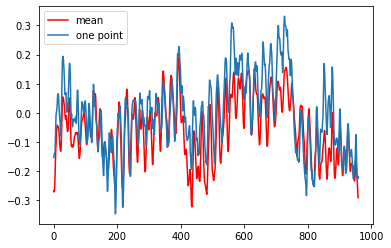

In [140]:
uu=u.data.reshape(u.shape[0],-1).mean(axis=-1)
plt.plot(uu,'r',label='mean')
plt.plot(u.data[:,0,0],label='one point')
plt.legend()

## Get u,v,tx,ty for a subtropical region south of KE

In [212]:
lon0,lat0=145,35
ddeg = 0.25
model_time=coas_model.U['U'].time

vns=['U','V','TX','TY']
dd = coas_model
data0 = [dd.U, dd.V, dd.TX, dd.TY]
data1 = []
for vn, din in zip(vns,data0):
    dtm=din.sel(time=slice('2020-02-09','2020-02-18'))[vn].sel(
        lon=slice(lon0-ddeg,lon0+ddeg),
        lat=slice(lat0-ddeg,lat0+ddeg))
    time=dtm.time
    dtm=dtm.data.reshape(time.size,-1).mean(axis=-1).compute()
    dtm=xr.DataArray(data=dtm,dims=('time'),coords={'time':time})
    if vn in ['U','V']:
        #dtm=slab_model.NIO_bandpass(dtm,lat0,[0.96,1.04])
        dtm_low,dtm_high=slab_model.filter_seperation(dtm,1/3)
    data1.append(dtm-dtm_low)


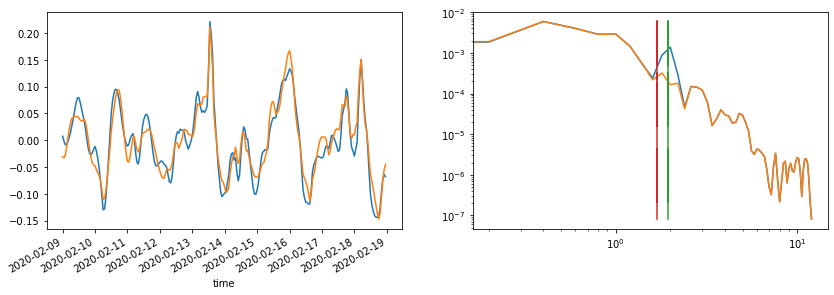

In [213]:
fig,ax=plt.subplots(1,2,figsize=(14,4))

data1[0].plot(ax=ax[0])
a,b=signal.welch(data1[0].data,nfft=5*24,nperseg=5*24,noverlap=60,detrend='linear',fs=24)
ax[1].loglog(a,b)

dtm = slab_model.remove_tides(data1[0:2],lat0,['M2','M4'])
data1[0:2]=dtm[:2]
dtm[0].plot(ax=ax[0])

a,b=signal.welch(dtm[0].data,nfft=5*24,nperseg=5*24,noverlap=60,detrend='linear',fs=24)
ax[1].loglog(a,b)
ax[1].loglog(np.ones_like(a)/12.4*24,b)
ax[1].loglog(np.ones_like(a)/14.25*24,b)


### Plot the time series to double check the validity

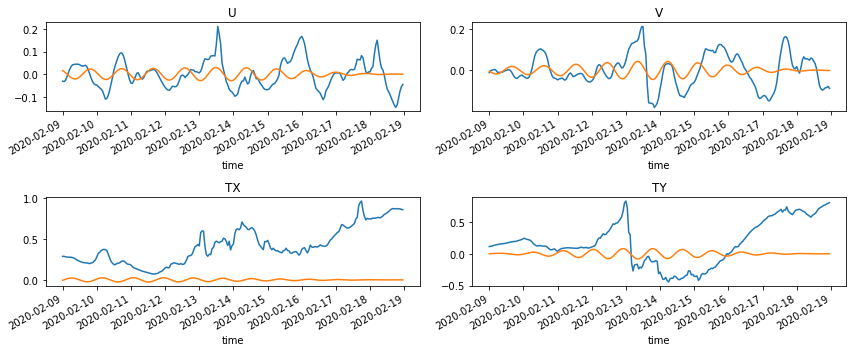

In [214]:
fig,axs=plt.subplots(2,2,figsize=(12,5))
for ax,dd, vn in zip(axs.flatten(),data1,vns):
    dd.plot(ax=ax)
    ax.plot(dd.time,slab_model.NIO_bandpass(dd,lat0,[0.9,1.1]))
    ax.set_title(vn)
plt.tight_layout()

## Optimize and find the NIO solution

### Find the satellite passing time

In [215]:
sat_time=odysea_class.wacmLatLon().getSamplingTimes([lat0],[lon0],data1[0].time[0].data,data1[0].time[-1].data)[0]
print(sat_time)

['2020-02-09T06:15:28.000000000' '2020-02-09T19:41:52.000000000'
 '2020-02-10T06:34:40.000000000' '2020-02-11T06:53:52.000000000'
 '2020-02-11T18:46:24.000000000' '2020-02-12T19:05:36.000000000'
 '2020-02-13T06:15:28.000000000' '2020-02-13T19:41:52.000000000'
 '2020-02-14T06:34:40.000000000' '2020-02-15T06:53:52.000000000'
 '2020-02-15T18:46:24.000000000' '2020-02-16T19:05:36.000000000'
 '2020-02-17T06:15:28.000000000' '2020-02-17T19:41:52.000000000'
 '2020-02-18T06:34:40.000000000']


### Generate (interpolate) model data onto the satellite passing time

In [216]:
data2 = []
for da in data1:
    data2.append(da.interp(time=sat_time))

data2[0]

<xarray.DataArray (time: 15)>
array([ 0.03604292, -0.01194189, -0.10935061, -0.01699907,  0.00020319,
        0.01835712,  0.06499753, -0.0438594 , -0.0305724 , -0.02245772,
        0.10105133, -0.04951594, -0.01703942,  0.04987116,  0.07771551])
Coordinates:
  * time     (time) datetime64[ns] 2020-02-09T06:15:28 ... 2020-02-18T06:34:40

### Check the original and odysea time series

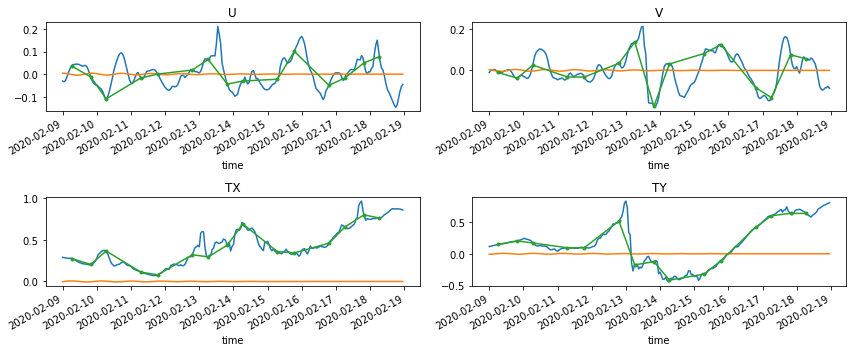

In [217]:
fig,axs=plt.subplots(2,2,figsize=(12,5))
for ax,dd1,dd2,vn in zip(axs.flatten(),data1,data2,vns):
    dd1.plot(ax=ax)
    ax.plot(dd1.time,slab_model.NIO_bandpass(dd1,lat0))
    dd2.plot(ax=ax,marker='.')
    ax.set_title(vn)
plt.tight_layout()

### Optimize

In [218]:
slab_result=slab_model.optimize_slab_noshear_withtide(data2[0].time.data,
                                          data2[0].data,data2[1].data,
                                          data2[2].time.data,
                                          data2[2].data,
                                          data2[3].data,
                                          utils.lat2f(lat0),
                                          has_tides=False,
                                          t_out=[],
                                          T_tide=[],
                                          is_windstress=False,c_clim=40,c_max=100,c_min=30,use_weight=True)
slab_result

<xarray.Dataset>
Dimensions:          (time: 217)
Coordinates:
  * time             (time) datetime64[ns] 2020-02-09T06:15:28 ... 2020-02-18...
Data variables:
    nio_u_predicted  (time) float64 0.03092 0.01866 ... -0.0216 -0.02311
    nio_v_predicted  (time) float64 -0.02489 -0.03337 ... 0.002624 0.008323
    H                float64 71.74
    c                float64 1.194e-06
    cost             float64 0.04228
    success          bool True

### plot the predicted velocity

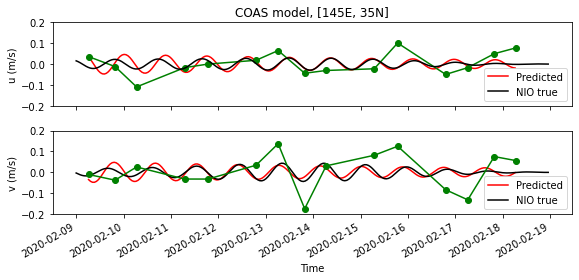

In [221]:
fig,ax=plt.subplots(2,1,figsize=(8,4),sharex=True,sharey=True)

u=slab_result.nio_u_predicted.sel(time=slice('2020-02-09','2020-02-18'));u-=u.mean()
u.plot(ax=ax[0],label='Predicted',color='r',)
u=slab_model.NIO_bandpass(data1[0],lat0,[0.9,1.1]).sel(time=slice('2020-02-09','2020-02-18'));u-=u.mean()
data2[0].sel(time=slice('2020-02-09','2020-02-18')).plot(ax=ax[0],marker='o',color='g',)
u.plot(ax=ax[0],label='NIO true',color='k',)
ax[0].legend()
ax[0].set_title('COAS model, [145E, 35N]')

u=slab_result.nio_v_predicted.sel(time=slice('2020-02-09','2020-02-18'));u-=u.mean()
u.plot(ax=ax[1],color='r',label='Predicted')
u=slab_model.NIO_bandpass(data1[1],lat0,[0.9,1.1]).sel(time=slice('2020-02-09','2020-02-18'));u-=u.mean()
u.plot(ax=ax[1],color='k',label='NIO true')
data2[1].sel(time=slice('2020-02-09','2020-02-18')).plot(ax=ax[1],marker='o',color='g',)

ax[1].legend()
plt.tight_layout()
ax[0].set_ylim(-0.2,0.2)
ax[0].set_ylabel('u (m/s)')
ax[1].set_ylabel('v (m/s)')
ax[1].set_xlabel('Time')
ax[0].set_xlabel('')
plt.savefig('coas_ke_example.pdf')

## Create coarser grid


In [ ]:
import glob, os, sys
sys.path.append('../src')
sys.path.append('../')
import slab_model
import pylab as plt
import numpy as np
import xarray as xr
import pandas as pd
import odysea_class
import utils
from scipy import signal
import coas
xrod=xr.open_dataset

coas_model = coas.COAS(days=45)


## Loop through global


In [122]:
import glob, os, sys
sys.path.append('../src')
sys.path.append('../')
import slab_model
import pylab as plt
import numpy as np
import xarray as xr
import pandas as pd
import odysea_class
import utils
from scipy import signal
import coas
xrod=xr.open_dataset

coas_model = coas.COAS(days=14)

def getit(lon0,lat0):
    ddeg = 0.2
    model_time=coas_model.U['U'].time

    vns=['U','V','TX','TY']
    dd = coas_model
    data0 = [dd.U, dd.V, dd.TX, dd.TY]
    data1 = []
    for vn, din in zip(vns,data0):
        dtm=din[vn].sel(
            lon=slice(lon0-ddeg,lon0+ddeg),
            lat=slice(lat0-ddeg,lat0+ddeg))
        dtm=dtm.data.reshape(model_time.size,-1).mean(axis=-1).compute()
        dtm=xr.DataArray(data=dtm,dims=('time'),coords={'time':model_time})
        if vn in ['U','V']:
            #dtm=slab_model.NIO_bandpass(dtm,lat0,[0.96,1.04])
            dtm_low,dtm_high=slab_model.filter_seperation(dtm,1/5)
        data1.append(dtm-dtm_low)
        
    dtm = slab_model.remove_tides(data1[0:2],lat0,['M2','M4'])
    data1[0:2]=dtm[:2]
    
    sat_time=odysea_class.wacmLatLon().getSamplingTimes([lat0],[lon0],model_time[0].data,model_time[-1].data)[0]
    data2 = []
    for da in data1:
        data2.append(da.interp(time=sat_time))
        
    sr=slab_model.optimize_slab_noshear_withtide(data2[0].time.data,
                          data2[0].data,data2[1].data,
                          data2[2].time.data,
                          data2[2].data,
                          data2[3].data,
                          utils.lat2f(lat0),
                          has_tides=False,
                          t_out=[],
                          T_tide=[],
                          is_windstress=False,c_clim=40,c_max=100,c_min=30,use_weight=True)
    nn=dtm[0].size 
    n0=nn//4
    d={'u_pred':sr.nio_u_predicted,
       'v_pred':sr.nio_v_predicted,
       'u_nio':slab_model.NIO_bandpass(data1[0],lat0,[0.96,1.04]),
       'v_nio':slab_model.NIO_bandpass(data1[1],lat0,[0.96,1.04])}
       
    return xr.Dataset(d)

dd=getit(-145,50)

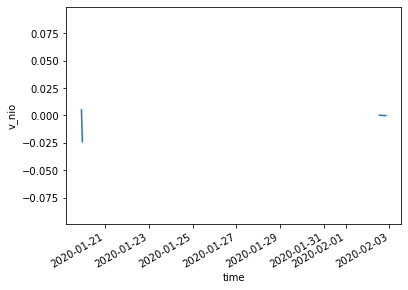

In [125]:
dd['v_nio'].plot()